In [2]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [54]:
g = 9.81 #重力加速度
m = 0.03 #質点の質量
k = 0.1 #バネ定数
l = 1 #バネの自然長

ns = 3 #バネの個数

nu = 3 #制御変数の次元
nx = 6*ns+3 #状態変数の次元

# コスト関数の重み
beta = 25
gamma = 1
delta = 0.01

# 予測ホライズン等
T = 8
K = 40
dt = T/K

# 制約条件
x_lb = [-np.inf]*nx
x_ub = [np.inf]*nx
u_lb = [-1]*nu
u_ub = [1]*nu

pos_end = casadi.DM([1,0,0])
vel = casadi.DM([-1,1,1])

total = nx*(K+1) + nu*K

In [55]:
def make_spring_force():
    pos_i = casadi.SX.sym("pos_i",3)
    pos_j = casadi.SX.sym("pos_j",3)
    pos_ji = pos_j - pos_i
    norm = casadi.norm_2(pos_ji)
    force = k*(norm - l)*pos_ji/norm

    F = casadi.Function("F",[pos_i,pos_j],[force],['x','y'],['F'])
    return F

def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    pos_0 = casadi.DM.zeros(3)
    G = casadi.DM([0,0,g])
    F = make_spring_force()

    offset = 3*(ns+1)

    X_dot = []
    V_dot = []

    for k in range(ns):
        pos_dot = states[offset+3*k:offset+3*(k+1)]
        X_dot.append(pos_dot)

        pos_now = states[3*k:3*(k+1)]
        pos_next = states[3*(k+1):3*(k+2)]
        pos_prev = states[3*(k-1):3*k] if k != 0 else pos_0
        pos_ddot = (F(x=pos_now,y=pos_next)["F"]-F(x=pos_prev,y=pos_now)["F"])/m - G
        V_dot.append(pos_ddot)

    states_dot = casadi.vertcat(*X_dot,ctrls,*V_dot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(states,ctrls):
    pos_last = states[3*ns:3*(ns+1)]
    pos_diff = pos_last - pos_end
    l1 = beta*casadi.dot(pos_diff,pos_diff)

    offset = 3*(ns+1)
    l2 = 0
    for i in range(ns):
        pos_dot = states[offset+3*i:offset+3*(i+1)]
        l2 += gamma*casadi.dot(pos_dot,pos_dot)
        
    l3 = delta * casadi.dot(ctrls,ctrls)
    cost = l1 + l2 + l3
    return cost

In [56]:
def make_nlp():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)

    option = {'print_time':True,'ipopt':{'print_level':5}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [57]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [58]:
S = make_nlp()

In [59]:
poss = np.stack([np.linspace(0,1,ns+2)[1:],np.zeros(ns+1),np.zeros(ns+1)],axis=1)
vels = np.zeros((ns,3))
x_current = np.concatenate([poss,vels],axis=0)
x_current = casadi.DM(x_current.ravel())
x0 = casadi.DM(np.random.normal(size=total))
compute_optimal_control(S,x_current,x0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    15495
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    11706

Total number of variables............................:      960
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.................:      840
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.5332767e+02 5.65e+00 1.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

(DM([0.890072, -0.622276, 0.999163]),
 DM([0.25, 0, 0, 0.5, 0, 0, 0.75, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.248464, -2.63511e-12, -0.202137, 0.5, 4.72966e-12, -0.1962, 0.758443, 0.0046484, -0.206857, 1.17801, -0.124455, 0.199833, -0.03906, -4.55505e-13, -2.06817, 0.0012298, -0.00239017, -1.95822, 0.135325, 0.0590186, -2.10266, 0.212945, 5.74866e-05, -0.843663, 0.501396, -0.00227202, -0.776334, 0.824722, 0.0215255, -0.840001, 1.01775, -0.171603, 0.390175, -0.363785, 0.00121926, -4.32923, 0.0150322, -0.0247203, -3.81654, 0.553405, 0.0991377, -4.18105, 0.0972741, 0.000882368, -1.90708, 0.506069, -0.0113291, -1.71262, 0.977185, 0.0408233, -1.84114, 0.846996, -0.0876442, 0.577394, -0.780575, 0.00804887, -6.19856, 0.0287542, -0.0676382, -5.53843, 0.94037, 0.0906416, -5.70143, -0.0884776, 0.00349373, -3.26737, 0.511525, -0.0292788, -2.99539, 1.18303, 0.0571581, -3.05932, 0.70308, -0.0434874, 0.751165, -1.04575, 0.0181401, -7.24402, 0.0247923, -0.110788, -7.31218, 1.06917, 0.0714797, -


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



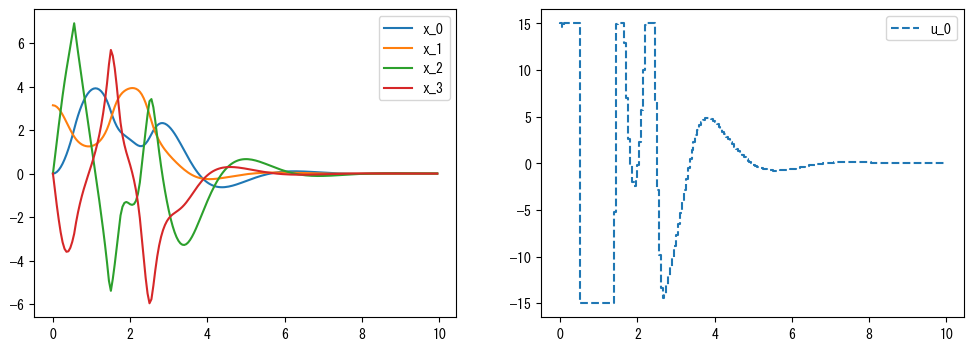

In [7]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([0,np.pi,0,0]) # 初期値
x0 = casadi.DM.zeros(total)

I = make_integrator()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

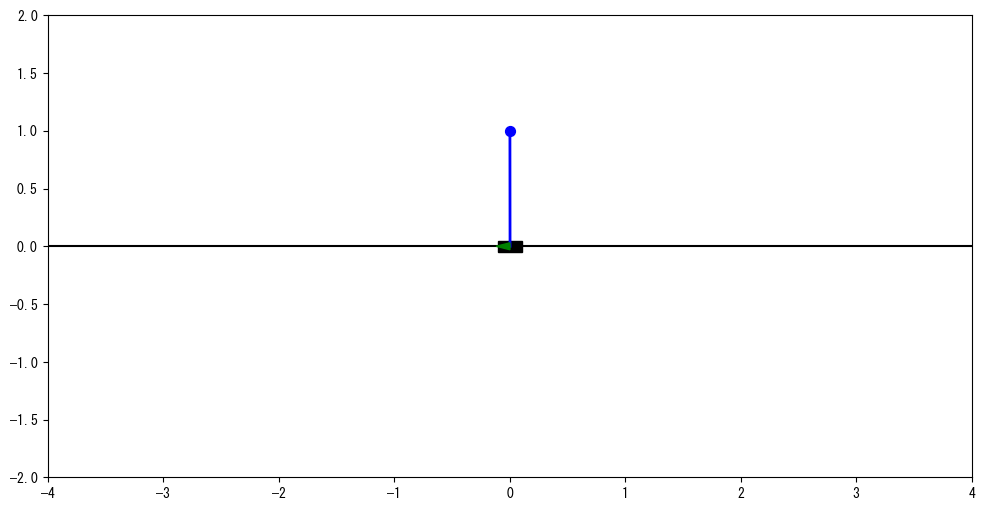

In [8]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
frames = np.arange(0,t_eval.size)
fps = 1 / dt

def update_figure(i):
    x_lim_min = -4
    x_lim_max = 4
    y_lim_min = -2
    y_lim_max = 2
    u_scale = 15

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_aspect("equal")

    x,theta,_,_ = X[i]
    u, = U[i]

    points = np.array([
        [x,x-l*np.sin(theta)],
        [0,l*np.cos(theta)]
    ])

    ax.hlines(0,x_lim_min,x_lim_max,colors="black")
    ax.scatter(*points,color="blue", s=50)
    ax.plot(*points, color='blue', lw=2)
    ax.arrow(x,0,u/u_scale,0,width=0.02,head_width=0.06,head_length=0.12,length_includes_head=False,color="green",zorder=3)

    w = 0.2
    h = 0.1
    rect = patches.Rectangle(xy=(x-w/2,-h/2), width=w, height=h,color="black")
    ax.add_patch(rect)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("images/chap5_cart_pole.gif",writer="pillow",fps=fps)

In [59]:
# import glob
# import natsort
# import cv2
# for i in np.linspace(0,199,12):
#     i = int(i)
#     update_figure(i)
#     fig.savefig(f"./tmp/_frame_{i}.png")
# paths = glob.glob("./tmp/*.png")
# paths = natsort.natsorted(paths)
# paths = [cv2.imread(path) for path in paths]
# paths = np.stack(paths,axis=0)
# paths = paths.reshape(4,3,600,1200,3)
# paths = np.concatenate(paths,axis=1)
# paths = np.concatenate(paths,axis=1)
# # paths = cv2.resize(paths,dsize=None,fx=1/3,fy=1/3)
# cv2.imwrite("images/chap5_cart_pole_anim.png",paths)

True